# **PCLab#3 - Group 2 - Morresi Masia Valdo**

This is the **third PC lab** of group 2. Here, we're part of a sophisticated hedge fund aiming to explore Twitter's predictive power in finance. Our first task is to conduct *sentiment analysis* on recent financial tweets. Additionally, we're tasked with developing a firm-level measure of media attention—a potentially *groundbreaking factor* for our investment strategies. Let's dive into this exciting analysis and unlock the potential of social media in financial forecasting.

## **Disclaimer: What is Sentiment Analysis?**

*Sentiment analysis is a technique used to analyze and gauge the emotional tone or sentiment expressed in written text. In finance, this is particularly valuable because it allows us to tap into public perceptions and opinions about financial markets, companies, or economic conditions. Understanding these sentiments can help investors and financial analysts make more informed decisions, predict market movements, and anticipate shifts in investor behavior. It's a tool that allows us to integrate **human sentiment** into the analytical framework of finance, enhancing our understanding of market dynamics.*

In [ ]:
# !pip uninstall -y transformers accelerate
# !pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00


In [ ]:
# ! pip install wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Utilities
from collections import Counter
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Cleaning
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Modeling
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Transformers
from transformers import pipeline

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Finance with Big Data/Lab3

# Task #1
### *Basic manipulation and descriptive statistics*

At first we import the dataset and we inspect it.
We can see that the dataset is made of two columns:
- *Text*: the text of the tweet;
- *Sentiment*: the sentiment of the tweet (negative or positive, encoded as 0, 1).

In [ ]:
tweets = pd.read_csv('./data/Data_PCLab3_Twitter_Stock_Sentiment.csv')
tweets

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


Then we want to analyze the distribution of the sentiments in the dataset. The optimal dataset would have a balanced distribution of the sentiments.

In [ ]:
tweets.Sentiment.value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

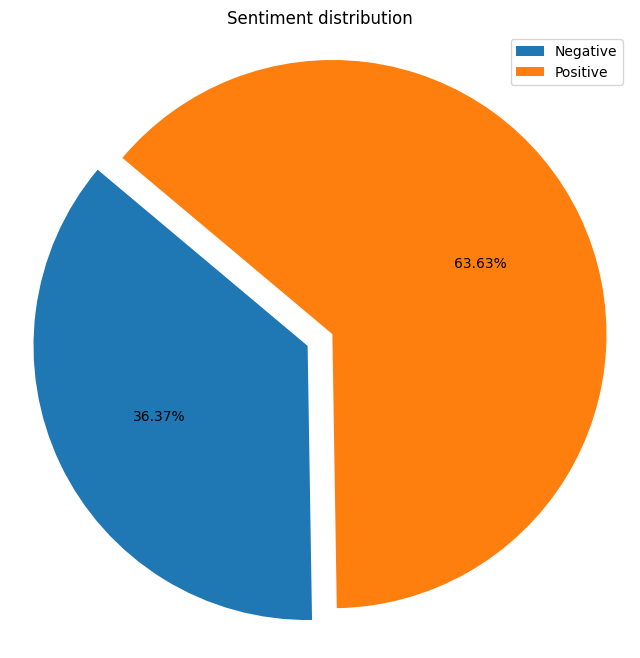

In [ ]:
# Plot a pie chart of the distribution of the sentiments

plt.figure(figsize=(8, 8))

# Data to plot
labels = 'Negative', 'Positive'
sizes = [tweets.Sentiment.value_counts()[0], tweets.Sentiment.value_counts()[1]]
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=None, autopct='%1.2f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.title("Sentiment distribution")
plt.legend(labels, loc="best")
plt.show()

The dataset is unbalanced, with the proportion of positive and negative sentiments different to 50%. This unbalance may be a problem when training the model, as it may be biased towards the majority class.

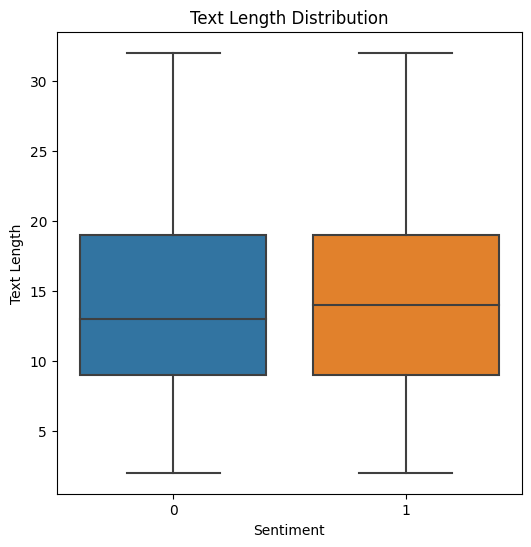

In [ ]:
# Plot the text length distribution for each sentiment

fig, ax = plt.subplots(figsize=(6, 6))

tweets['text_length'] = tweets.Text.apply(lambda x: len(str(x).split()))
sns.boxplot(x='Sentiment', y='text_length', data=tweets, ax=ax)

ax.set_xlabel("Sentiment")
ax.set_ylabel("Text Length")
ax.set_title("Text Length Distribution")

plt.show()

We can see that the distribution is almost the same, however the mean of positive tweets is slightly higher than the mean of negative tweets.

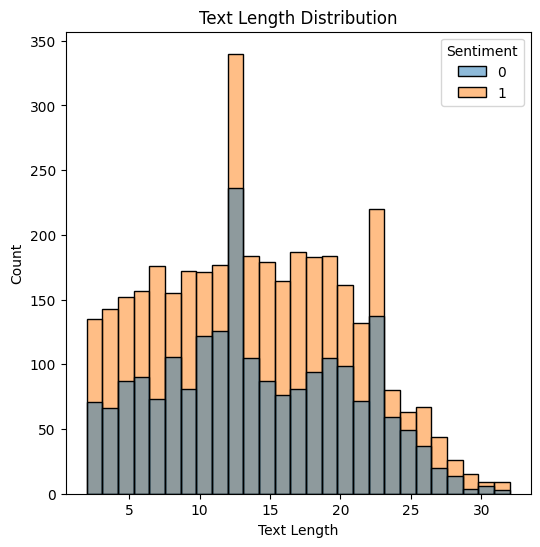

In [ ]:
# Plot the histogram of the length of the text for each sentiment

fig, ax = plt.subplots(figsize=(6, 6))

sns.histplot(x='text_length', hue='Sentiment', data=tweets, ax=ax)

ax.set_xlabel("Text Length")
ax.set_title("Text Length Distribution")

plt.show()

Secondly we wanted to analyze the distribution of the length of the tweets, measured as the number of words in the tweet. We can see that the distribution is almost the same, however since the dataset is unbalanced toward positive tweets, the histogram of positive tweets is slightly higher than the histogram of negative tweets.

In both classes, 12 and 22 are the most frequent lengths of the tweets, while once we reach 22 words, the frequency of the lengths of the tweets decreases.
Excluding the two most frequent lengths, the count of the lengths of the tweets is almost constant, oscillating between 50 and 100 for the negative tweets and around 150 for the positive tweets.

### **Disclaimer: problem with the data**


This dataset includes tweets along with their corresponding sentiments, but a significant piece of information is **missing—the date** of each tweet. Despite our ability to accurately identify the stocks mentioned in these tweets, we lack crucial temporal data. This absence poses a challenge when attempting to *analyze the correlation between sentiment and stock market movements* accurately. Sentiment about stocks can fluctuate over time due to various factors, and understanding these trends requires observing how sentiment changes and relates to market shifts. Major events significantly influence both stock prices and public sentiment. By associating sentiment changes with specific dates, we can grasp how these changes align with events like earnings reports, policy decisions, or market fluctuations. Analyzing sentiment across different market conditions allows us to identify patterns and correlations, offering insights into how sentiment aligns with market trends over time. Real-time analysis of sentiment, correlated with daily stock performance, is crucial for swift decision-making, especially for traders and short-term investors who need to react promptly to market changes. Additionally, examining sentiment over extended periods helps us identify long-term trends and comprehend how sentiment relates to the market over extended durations. To accurately explore the correlation between tweet sentiment and the stock market, it's imperative to align each sentiment with its corresponding date.

# Task #2
### Cleaning and visualization

The folllowing function *clean_text* is created to conduct this essential process aimed at preparing the text for subsequent analysis. First, the text is converted to lowercase to ensure consistency in the dataset. Next, punctuation is removed to focus on the essential words and phrases. This step helps in reducing noise and enhancing the accuracy of subsequent analyses. Following punctuation removal, common English stopwords (e.g., 'and', 'the', 'is') are eliminated to further refine the text. Stopwords are often removed as they typically carry little analytical value. In the commented-out section, there's an option to remove short words based on a specified length criterion, although it's currently inactiveLastly, lemmatization is applied to transform words into their base or root form, ensuring consistency and simplifying the dataset for subsequent analysis.

In [ ]:
# cleaning steps: remove punctuation, stopwords, short words, etc.

punctuation = string.punctuation
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(df):
    df = ''.join([w.lower() for w in df]) # lower text
    df = ''.join([w for w in df if w not in punctuation]) # remove punctuation
    df = ' '.join([w for w in df.split() if w not in stop_words]) # remove stopwords
    # df = ' '.join([w for w in df.split() if len(w) > 2]) # remove short words
    df = ' '.join([lemmatizer.lemmatize(w) for w in df.split()]) # lemmatize
    return df

In [ ]:
clean_text('$I love AI & Machine learning applied to Finance...!! ;)')

'love ai machine learning applied finance'

In [ ]:
# Clean the text

tweets['clean_text'] = tweets.Text.apply(clean_text)
tweets

,Text,Sentiment,clean_text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kicker watchlist xide tit soq pnk cpw bpz aj t...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user aap movie 55 return feageed indicator 15 ...
2,user I'd be afraid to short AMZN - they are lo...,1,user id afraid short amzn looking like nearmon...
3,MNTA Over 12.00,1,mnta 1200
4,OI Over 21.37,1,oi 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,gold price slip r 46000 investor book profit a...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,worker bajaj auto agreed 10 wage cut period ap...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,sharemarket live sensex day’s high 600 point n...


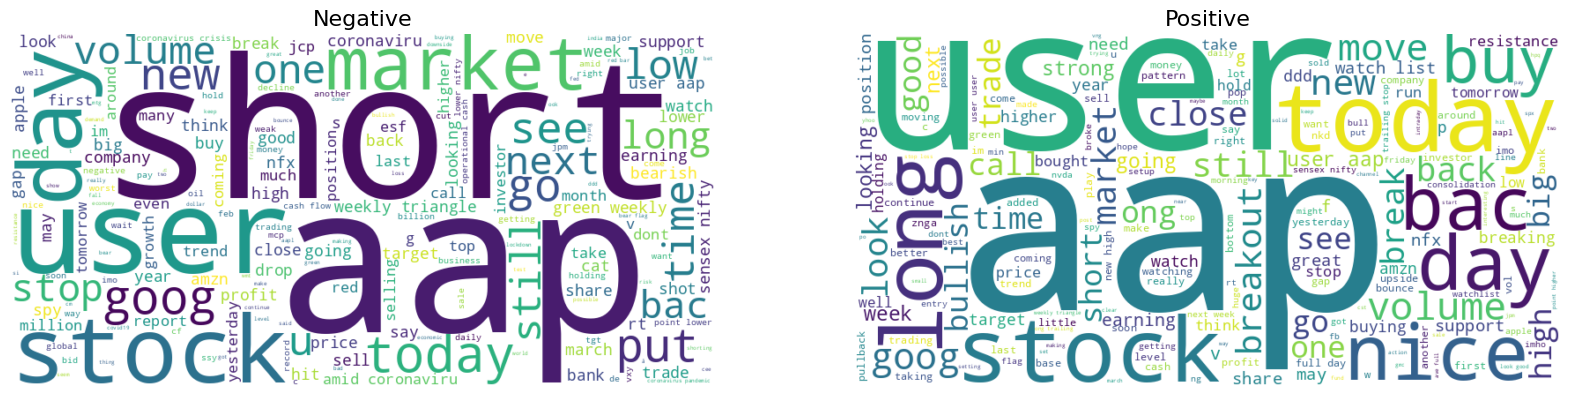

In [ ]:
# Plot a word cloud for text with positive and negative sentiment separately

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i in range(2):
    text = " ".join(post_text for post_text in tweets[tweets['Sentiment'] == i]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(text)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].set_title('Positive' if i == 1 else 'Negative', fontsize=16)

plt.show()

The composition of words in the word clouds for negative and positive tweets *resonates with established trading practices and sentiment analysis* within the stock market. Words such as "short" and "put" prominently featured in the negative sentiment word cloud are inherently associated with a bearish outlook. "Short" denotes the strategy of selling borrowed stocks with the belief that their value will decline, reflecting a negative sentiment towards the stock. Similarly, "put" signifies a bearish sentiment, as buying a put option allows one to sell a stock at a predetermined price, indicating an expectation of the stock's value decreasing. Conversely, the positive sentiment word cloud prominently displays terms like "buy," "long," and "call." "Buy" is fundamental, embodying a bullish sentiment where investors anticipate a rise in the stock's value. "Long" signifies the act of holding a position with optimistic expectations for the stock's growth, while "call" suggests a positive outlook, allowing the purchase of a stock at a predetermined price. These word associations distinctly mirror prevalent trading behaviors and underline the direct connection between words and the sentiment they convey in the financial domain.

In [ ]:
# What are the words that appear only once in the text?

words = Counter()
for i in range(len(tweets)):
    words.update(tweets.iloc[i]['clean_text'].split())

unique_words = [w for w in words if words[w] == 1]
print(f'In the dataset there are {len(unique_words)} words (lemmas) that appear only once')
print(f'Some examples are: {unique_words[-10:]}')

In the dataset there are 6555 words (lemmas) that appear only once
Some examples are: ['cii', 'discoms', 'httpstco8c6yjyjajl', '46000', 'httpstcofsylajruqv', 'httpstcorgvrkplind', 'sharemarket', 'httpstco3xgtlrokui', 'dstreet', 'httpstcojvqcousfp6']


We see that some of these words are meaningless (excluded those who are the processing of stock names).

# Task #3
### *Sentment analysis*

More usual steps: Tokenizing the text and padding
- Tokenize: vectorize text corpus, transform text into numbers
- Padding: make all sentences the same lenght (fill with 0 short sentences)


The code provided in the next lines of code does sentiment analysis on a dataset of tweets using a *Convolutional Neural Network* (CNN). It starts by splitting the data into training and testing sets. Text is then tokenized and padded. The CNN model is built using Keras, including layers like embedding, convolutional, global max-pooling, and dense layers. The model is compiled and trained, and training/validation accuracy and loss are plotted. Finally, a confusion matrix is created based on model predictions on the test set, offering insights into the model's performance in sentiment analysis.

In [ ]:
# Split the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(tweets['clean_text'], tweets['Sentiment'], test_size=0.1, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Tokenize the text

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the sequences

X_train = pad_sequences(X_train, padding='post', maxlen=50)
X_test = pad_sequences(X_test, padding='post', maxlen=50)

In [ ]:
# Build a CNN model

model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=50))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            511350    
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 544779 (2.08 MB)
Trainable params: 544779 (2.08 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Epoch 1/10
147/147 [==============================] - 36s 192ms/step - loss: 0.6139 - accuracy: 0.6492 - val_loss: 0.5321 - val_accuracy: 0.7701
Epoch 2/10
147/147 [==============================] - 4s 28ms/step - loss: 0.3636 - accuracy: 0.8533 - val_loss: 0.5195 - val_accuracy: 0.7625
Epoch 3/10
147/147 [==============================] - 4s 27ms/step - loss: 0.1469 - accuracy: 0.9539 - val_loss: 0.6466 - val_accuracy: 0.7490
Epoch 4/10
147/147 [==============================] - 4s 26ms/step - loss: 0.0532 - accuracy: 0.9855 - val_loss: 0.8333 - val_accuracy: 0.7241
Epoch 5/10
147/147 [==============================] - 2s 16ms/step - loss: 0.0197 - accuracy: 0.9962 - val_loss: 0.9571 - val_accuracy: 0.7261


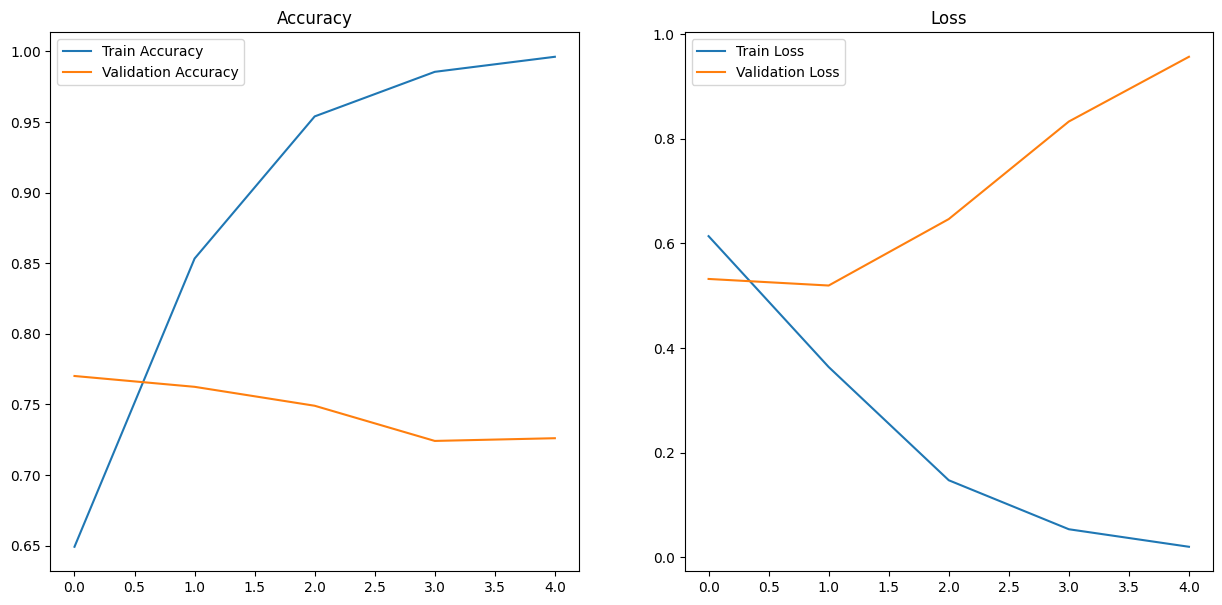

In [ ]:
# Train the model

history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                    )


# Plot the training and validation accuracy and loss for each epoch

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()

- Plot the confusion matrix and compute the **accuracy score** (e.g., with `sklearn` function `accuracy`)

19/19 [==============================] - 0s 4ms/step


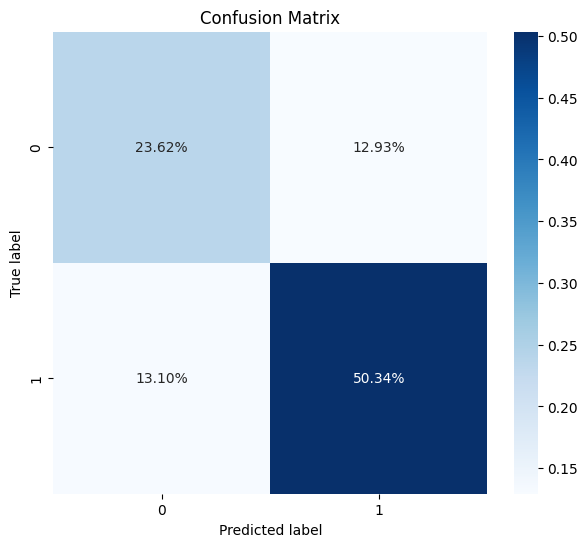

In [ ]:
# Print the confusion matrix

y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)


# Plot the confusion matrix and display the values as percentages
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()


In evaluating the performance of our sentiment prediction model for stock-related tweets, we analyzed the confusion matrix. Impressively, a significant portion of the predictions demonstrated accurate identification of positive sentiment, accounting for 50.34% of the total predictions. Additionally, we achieved a commendable accuracy of 23.62% in correctly classifying negative sentiment. However, it's worth noting that there were instances of misclassifications—13.10% false negatives and 12.93% false positives. False negatives indicated missed opportunities to recognize actual negative sentiment, while false positives pointed to erroneous categorizations of positive sentiment. These insights highlight areas for improvement in our model, suggesting potential adjustments to enhance accuracy and achieve a better balance between identifying positive and negative sentiments in stock-related tweets. Fine-tuning the model and optimizing the features based on these observations may be crucial to further enhance its predictive capabilities.

### XGBoost


The following code performs a comprehensive analysis of sentiment prediction for stock-related tweets using XGBoost, a popular machine learning algorithm known for its efficiency and accuracy. The code begins by defining a parameter grid, params, encapsulating various hyperparameters crucial for fine-tuning the *XGBoost* model. Through a randomized search approach facilitated by *RandomizedSearchCV*, the script explores different combinations of these hyperparameters, aiming to optimize the model's performance based on accuracy. After obtaining the best hyperparameters, an XGBoost classifier is initialized and trained with these optimal settings. Using this trained model, sentiment prediction is performed on a test dataset, and accuracy is calculated to gauge the model's predictive capability. The code then constructs a confusion matrix, providing a detailed breakdown of the model's classification accuracy for different sentiment labels.

In [ ]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [0, 1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='accuracy', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [0, 1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring='accuracy', verbose=3)

In [ ]:
xgb = XGBClassifier(**random_search.best_params_)
xgb.fit(X_train, y_train)
preds_xgb = xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, preds_xgb)

print('Accuracy:', accuracy_xgb)

Accuracy: 0.6775862068965517


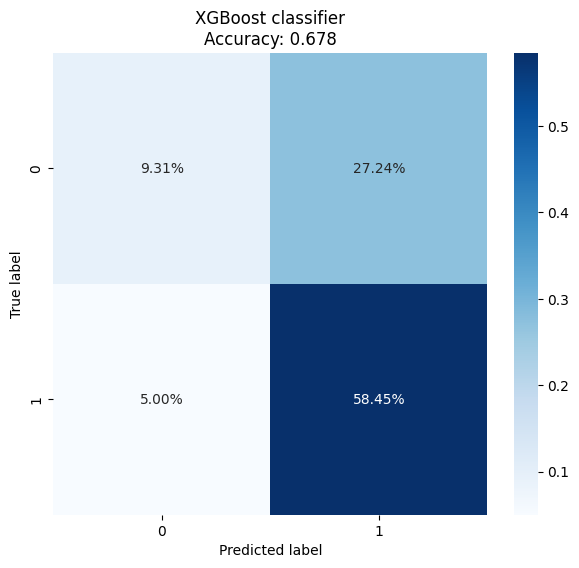

In [ ]:
# confusion matrix

cm = confusion_matrix(y_test, preds_xgb, labels=np.unique(y_train))

cm_df = pd.DataFrame(cm/np.sum(cm), index = np.unique(y_train),
                        columns = np.unique(y_train))

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt='.2%', cmap='Blues')
plt.title('XGBoost classifier\nAccuracy: {0:.3f}'.format(accuracy_xgb))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Comparing the sentiment analysis approaches using XGBoost and a CNN model sheds light on the distinct strengths and characteristics of each algorithm. The XGBoost approach, leveraging its prowess in efficiently capturing complex relationships across features, results in a notable enhancement in positive sentiment prediction, reaching up to 58.45%. This improvement suggests XGBoost's proficiency in discerning positive sentiment patterns within the dataset. However, this advantage comes at the cost of increased false positives, reaching up to 27.24%, indicating instances where the model incorrectly predicts positive sentiment. On the other hand, while using a CNN model, which is good in identifying local patterns of words which can affect sentiments, the false positives are reduced, implying a more cautious approach towards labeling positive sentiment. However, the implementation of an LSTM (which is a special case of the basic Recurrent-NN) could be beneficial, since these networks take into consideration also the sequential dependancies relations between words, which is a really useful feature with text data. Finally, this comparison underscores the importance of considering the model's tendencies, trade-offs, and the dataset's characteristics when selecting an appropriate approach for sentiment analysis. Depending on the desired balance between false positives and negatives, the choice of model can be optimized to best suit the specific objectives of the sentiment analysis task.

# Task #4
### Sentment analysis - Optional

Use transformers (BERT from Huggingface) to perform another sentiment
analysis and compare to the sentiment value in the data
- Use pipeline: from transformers import pipeline
- Use the already created library: text-classification or sentiment-analysis

For this first naive approach, we take a pre-trained model from HuggingFace which returns the classification on two labels ('POSITIVE' & 'NEGATIVE') so that we can avoid to retrain or fine-tune them.

Many models on the website are trained to classify texts also as 'NEUTRAL', which is an issue when it comes to compare the predictions of this model with the previous ones we trained.

In [ ]:
model_path = "siebert/sentiment-roberta-large-english"
sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)

In [ ]:
y_pred_hugg = []
for tweet in tqdm(tweets['clean_text']):
    y_pred_hugg.append(sentiment_classifier(tweet)[0]['label'])

y_pred_hugg = [0 if t == 'NEGATIVE' else 1 for t in y_pred_hugg] # Recode to 0, 1 as the original labels

100%|██████████| 5791/5791 [28:51<00:00,  3.34it/s]


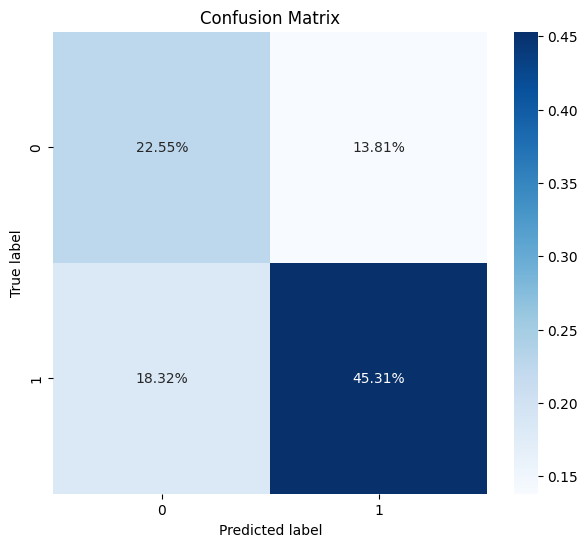

In [ ]:
# Print the confusion matrix

cm_hugg = confusion_matrix(y, y_pred_hugg)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_hugg / np.sum(cm_hugg), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

plt.show()

In [ ]:
print(f'The values on the diagonal represent the percentage of correct predictions, which are the following:\n'
      f'Negative sentiment: {round(cm_hugg[0][0] / np.sum(cm_hugg[0]) * 100, 2)}%\n'
      f'Positive sentiment: {round(cm_hugg[1][1] / np.sum(cm_hugg[1]) * 100, 2)}%')

The values on the diagonal represent the percentage of correct predictions, which are the following:
Negative sentiment: 62.01%
Positive sentiment: 71.21%


The performances are slightly lower than the first classifier we build. Maybe if we fine-tune this model (or even others) we can get better results.

### BERT Classifier Fine-Tuning

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer_class = BertTokenizer.from_pretrained('bert-base-uncased')
model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [ ]:
# Split the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(tweets['clean_text'], tweets['Sentiment'], test_size=0.1, random_state=42)

In [ ]:
# Tokenize the text

X_train = tokenizer_class(X_train.tolist(), padding=True, truncation=True, max_length=50)
X_test = tokenizer_class(X_test.tolist(), padding=True, truncation=True, max_length=50)

In [ ]:
# Build the model

model = model_class.from_pretrained('bert-base-uncased', num_labels=2)
model.to('cuda')

In [ ]:
# Train the model

X_train = {key: torch.tensor(val) for key, val in X_train.items()}
X_test = {key: torch.tensor(val) for key, val in X_test.items()}
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train['input_ids']), torch.tensor(X_train['attention_mask']), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test['input_ids']), torch.tensor(X_test['attention_mask']), torch.tensor(y_test))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for _, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        ids = data[0].to('cuda')
        mask = data[1].to('cuda')
        targets = data[2].to('cuda')

        outputs = model(ids, mask, labels=targets)
        optimizer.zero_grad()
        loss = outputs[0]
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}, Loss:  {loss.item()}')

def validation(epoch):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            ids = data[0].to('cuda')
            mask = data[1].to('cuda')
            targets = data[2].to('cuda')

            outputs = model(ids, mask).logits
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

for epoch in range(3):
    train(epoch)

In [ ]:
outputs, targets = validation(epoch=1)
outputs = np.argmax(outputs, axis=1)
accuracy = accuracy_score(targets, outputs)
print(f'\nAccuracy Score = {accuracy}')

100%|██████████| 19/19 [00:01<00:00, 12.93it/s]


Accuracy Score = 0.7913793103448276


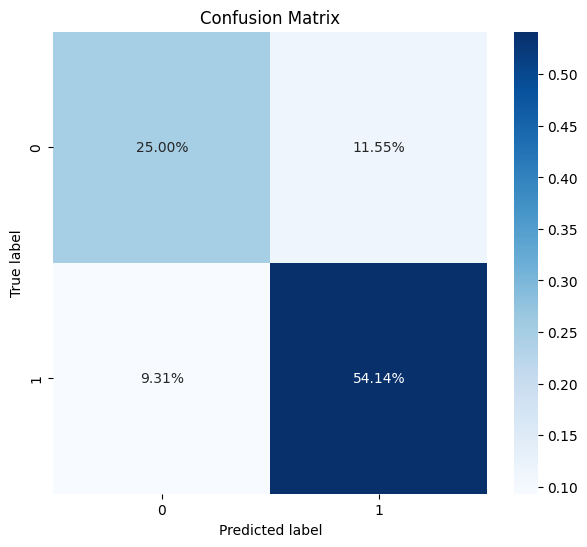

In [ ]:
# Print the confusion matrix

cm = confusion_matrix(targets, outputs)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

plt.show()

To go further: check [FinBERT](https://github.com/ProsusAI/finBERT)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer_class = BertTokenizer.from_pretrained('ProsusAI/finbert')
model_class = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=2, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(tweets['clean_text'], tweets['Sentiment'], test_size=0.1, random_state=42)

In [ ]:
# Tokenize the text

X_train = tokenizer_class(X_train.tolist(), padding=True, truncation=True, max_length=50)
X_test = tokenizer_class(X_test.tolist(), padding=True, truncation=True, max_length=50)

In [ ]:
# Build the model

model = model_class.from_pretrained('ProsusAI/finbert', num_labels=2, ignore_mismatched_sizes=True)
model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Train the model

X_train = {key: torch.tensor(val) for key, val in X_train.items()}
X_test = {key: torch.tensor(val) for key, val in X_test.items()}
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train['input_ids']), torch.tensor(X_train['attention_mask']), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test['input_ids']), torch.tensor(X_test['attention_mask']), torch.tensor(y_test))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for _, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        ids = data[0].to('cuda')
        mask = data[1].to('cuda')
        targets = data[2].to('cuda')

        outputs = model(ids, mask, labels=targets)
        optimizer.zero_grad()
        loss = outputs[0]
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}, Loss:  {loss.item()}')

def validation(epoch):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            ids = data[0].to('cuda')
            mask = data[1].to('cuda')
            targets = data[2].to('cuda')

            outputs = model(ids, mask).logits
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

for epoch in range(3):
    train(epoch)

<ipython-input-26-1a0aa437e6bb>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train['input_ids']), torch.tensor(X_train['attention_mask']), torch.tensor(y_train))
<ipython-input-26-1a0aa437e6bb>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test['input_ids']), torch.tensor(X_test['attention_mask']), torch.tensor(y_test))
100%|██████████| 163/163 [00:37<00:00,  4.35it/s]


Epoch: 0, Loss:  0.4802098572254181


100%|██████████| 163/163 [00:37<00:00,  4.34it/s]


Epoch: 1, Loss:  0.36124300956726074


100%|██████████| 163/163 [00:39<00:00,  4.14it/s]

Epoch: 2, Loss:  0.2952994704246521


In [ ]:
outputs, targets = validation(epoch=1)
outputs = np.argmax(outputs, axis=1)
accuracy = accuracy_score(targets, outputs)
print(f'\nAccuracy Score = {accuracy}')

100%|██████████| 19/19 [00:01<00:00, 13.10it/s]


Accuracy Score = 0.7793103448275862


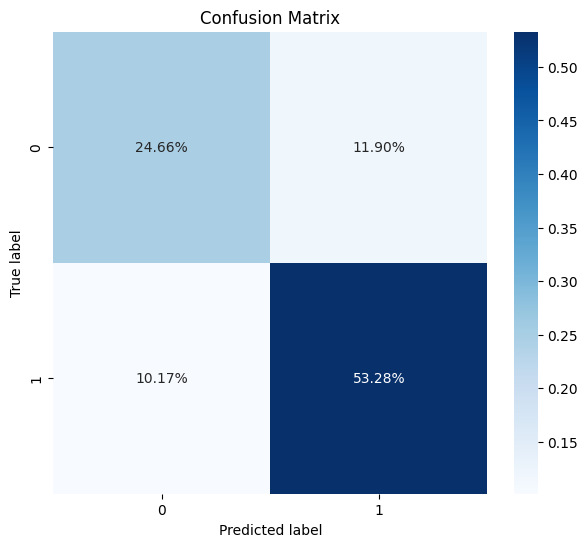

In [ ]:
# Print the confusion matrix

cm = confusion_matrix(targets, outputs)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

plt.show()

# Task #5
### Measuring media attention

- Use the list of tickers gathered during last PC Lab (see the web-scrapping part) to compute the number of tweets about each stock

In [ ]:
data_lab1 = pd.read_csv('./data/Data_PCLab1_Stock.csv')
data_lab1.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [ ]:
yahoo = pd.read_csv('./data/data_lab2_yahoo.csv', header=[0,1], index_col=0, parse_dates=True)
yahoo.head()

AES                                                 AZO  \
             Open   High    Low  Close Adj Close   Volume        Open   
Date                                                                    
2012-01-03  12.03  12.21  11.85  12.12  8.746440  7312000  327.720001   
2012-01-04  12.05  12.20  12.01  12.03  8.681490  3675600  318.230011   
2012-01-05  12.02  12.38  11.90  12.32  8.890772  8710600  323.980011   
2012-01-06  12.28  12.38  12.14  12.23  8.825824  7463600  333.850006   
2012-01-09  12.23  12.51  12.17  12.47  8.999019  6515500  337.980011   

                                                ...         DE             \
                  High         Low       Close  ...        Low      Close   
Date                                            ...                         
2012-01-03  328.489990  318.119995  319.790009  ...  78.839996  79.309998   
2012-01-04  327.910004  313.109985  326.959991  ...  79.129997  80.470001   
2012-01-05  334.100006  321.190002  333.850006  ...  80.120003  81.639999   
2012-01-06  339.230011  331.929993  338.040009  ...  81.139999  82.300003   
2012-01-09  340.510010  336.450012  339.500000  ...  82.220001  82.730003   

                                HBAN                                        
            Adj Close   Volume  Open  High   Low Close Adj Close    Volume  
Date                                                                        
2012-01-03  62.865494  3317300  5.63  5.76  5.61  5.63  3.742677  12481800  
2012-01-04  63.784962  4381900  5.60  5.74  5.56  5.68  3.775916  10223300  
2012-01-05  64.712379  3498500  5.65  5.83  5.56  5.79  3.849040  12469200  
2012-01-06  65.235558  3839500  5.81  5.85  5.73  5.80  3.855687  10175000  
2012-01-09  65.576385  3501300  5.78  5.88  5.74  5.86  3.895575  14953500  

[5 rows x 3018 columns]

After having loaded the dataset used in the previous PCLab, we create a DataFrame object with the following columns: 'Stock', 'Number of tweets', 'Positive tweets', 'Negative tweets'.

Then we iterate for each stock in the dataset to find the occurrencies of the stocks names in the sentiment dataset. The seach is perfomed using a RegEx. In particular, the regular expression `r'\b\$?' + re.escape(stock.lower()) + r'\b'` is composed of:

1. `r'\b'`: This part of the regex is a word boundary anchor. `\b` is a zero-width assertion that matches the position between a word character (as defined by `\w`) and a non-word character (anything that is not a word character). It is used to ensure that the match occurs at the beginning or end of a word.

2. `'\$?'`: This part matches an optional dollar sign ('$'). The `\$` is used to escape the dollar sign because it has a special meaning in regular expressions (it matches the end of a line). The `?` makes the dollar sign optional, meaning that it can occur zero or one time in the input string.

3. `re.escape(stock.lower())`: This part generates a regular expression pattern from the `stock` variable after making it lowercase and escaping any special characters. Here's what it does:
   - `stock.lower()`: Converts the content of the `stock` variable to lowercase. This is done to make the pattern matching case-insensitive.
   - `re.escape()`: Escapes any special characters in the lowercase `stock` string. For example, if `stock` contains characters like '.', '*', '?', or other regex metacharacters, they will be escaped so that they are treated as literal characters in the pattern.

4. `r'\b'`: This is another word boundary anchor, similar to the first one, ensuring that the match occurs at the beginning or end of a word.

In [ ]:
import re

stocks = yahoo.columns.get_level_values(0).unique()
df_sentiment = pd.DataFrame(columns=['Stock', 'Number of tweets', 'Positive tweets', 'Negative tweets'])

for stock in stocks:
    pattern = r'\b\$?' + re.escape(stock.lower()) + r'\b'
    df_sentiment = pd.concat([df_sentiment, pd.DataFrame([[stock,
                                                           len(tweets[tweets.clean_text.str.contains(pattern)]),
                                                           len(tweets[(tweets.clean_text.str.contains(pattern)) & (tweets.Sentiment == 1)]),
                                                           len(tweets[(tweets.clean_text.str.contains(pattern)) & (tweets.Sentiment == 0)])]],
                                                           columns=['Stock', 'Number of tweets', 'Positive tweets', 'Negative tweets'])]).sort_values(by='Number of tweets', ascending=False)

In [ ]:
df_sentiment.head()

,Stock,Number of tweets,Positive tweets,Negative tweets
0,BAC,200,151,49
0,GOOG,198,127,71
0,SEE,165,100,65
0,LOW,121,58,63
0,AMZN,108,61,47


### Rank the stocks

In [ ]:
top10_tweets = df_sentiment.sort_values(by='Number of tweets', ascending=False).head(10)
top10_positive = df_sentiment.sort_values(by='Positive tweets', ascending=False).head(10)
top10_negative = df_sentiment.sort_values(by='Negative tweets', ascending=False).head(10)

print(f'Top 10 stocks with the highest number of tweets:({list(zip(top10_tweets.Stock.values,top10_tweets["Number of tweets"].values))})')
print(f'Top 10 stocks with the highest number of positive tweets:({list(zip(top10_positive.Stock.values,top10_positive["Positive tweets"].values))})')
print(f'Top 10 stocks with the highest number of negative tweets:({list(zip(top10_negative.Stock.values,top10_negative["Negative tweets"].values))})')

Top 10 stocks with the highest number of tweets:([('BAC', 200), ('GOOG', 198), ('SEE', 165), ('LOW', 121), ('AMZN', 108), ('V', 102), ('WELL', 91), ('F', 73), ('ED', 67), ('C', 59)])
Top 10 stocks with the highest number of positive tweets:([('BAC', 151), ('GOOG', 127), ('SEE', 100), ('V', 75), ('WELL', 68), ('F', 64), ('AMZN', 61), ('LOW', 58), ('ED', 48), ('C', 38)])
Top 10 stocks with the highest number of negative tweets:([('GOOG', 71), ('SEE', 65), ('LOW', 63), ('BAC', 49), ('AMZN', 47), ('CAT', 41), ('V', 27), ('WELL', 23), ('CF', 22), ('DE', 21)])


We can see that more or less the ranks are similar, no matter the tweets that we are considering. This means that the tweets overall do not have a particular sentiment for each stock. This may be due to the fact that the dataset of tweets does not comprehend the date of the posts.

Also, we need to take into account that the count may be biased, since words such as "low" or "well" may refer to adverbs rather to stock codes. Filter this kind of edge cases is almost impossible, since they depend on the correct writing of each tweet. In fact, in the RegEx expression we accounted for a $ sign at the beginning of the stock name, since usually that is what users do when tweeting about a stock, however the occurrencies of this kind are rather unusual.

One may think that to discriminate between the stock code and a common word we could use the case matching, as we expect that stocks names will be written as "GOOG" or "AAPL" and not "goog" or "aapl". However, in the dataset we often have the opposite, especially for tweets regarding Apple stock. We then faced a trade-off and we decided to take into account unrelevant tweet too. At least we know that our estimates are upward biased, rather than completely omitting the tweets about a given stock.

### Correlation

**Disclaimer**


*Analyzing the correlation between media attention and excess return is difficult when sentiment data and stock prices don't have matching dates. Without this synchronization, it's hard to draw reliable conclusions, and there can be inaccuracies. Aligning sentiment data with stock prices using timestamps or dates is crucial for a meaningful correlation analysis. If this alignment isn't possible, exploring alternative analyses like sentiment trend analysis or aggregated sentiment data over specific periods can provide insights into potential correlations, even if a direct causal relationship can't be determined.*

The *alltime_ret* variable represents the log returns for each stock in selected stocks over the entire period. This variable will be used in the scatter plots to analyze the relationship between these log returns and various sentiment-related metrics.



In [ ]:
# Hypothesizing that tweets are related to the entire period, since we have no dates
selected_stocks = data_lab1.columns[1:-1]
alltime_ret = np.log(data_lab1[selected_stocks].iloc[-1] / data_lab1[selected_stocks].iloc[0])*100
alltime_ret.sort_index(inplace=True)
alltime_ret


AAPL    198.342811
AMZN    286.281621
BA       86.941372
GOOG    155.175373
IBM     -35.379112
MGM      57.237121
T         0.265252
TSLA    388.467183
dtype: float64

The following lines of code create a scatter plot for analyzing the relationship between all-time return percentages (ATR) and various sentiment-related metrics (number of tweets, positive tweets, and negative tweets) for selected stocks.

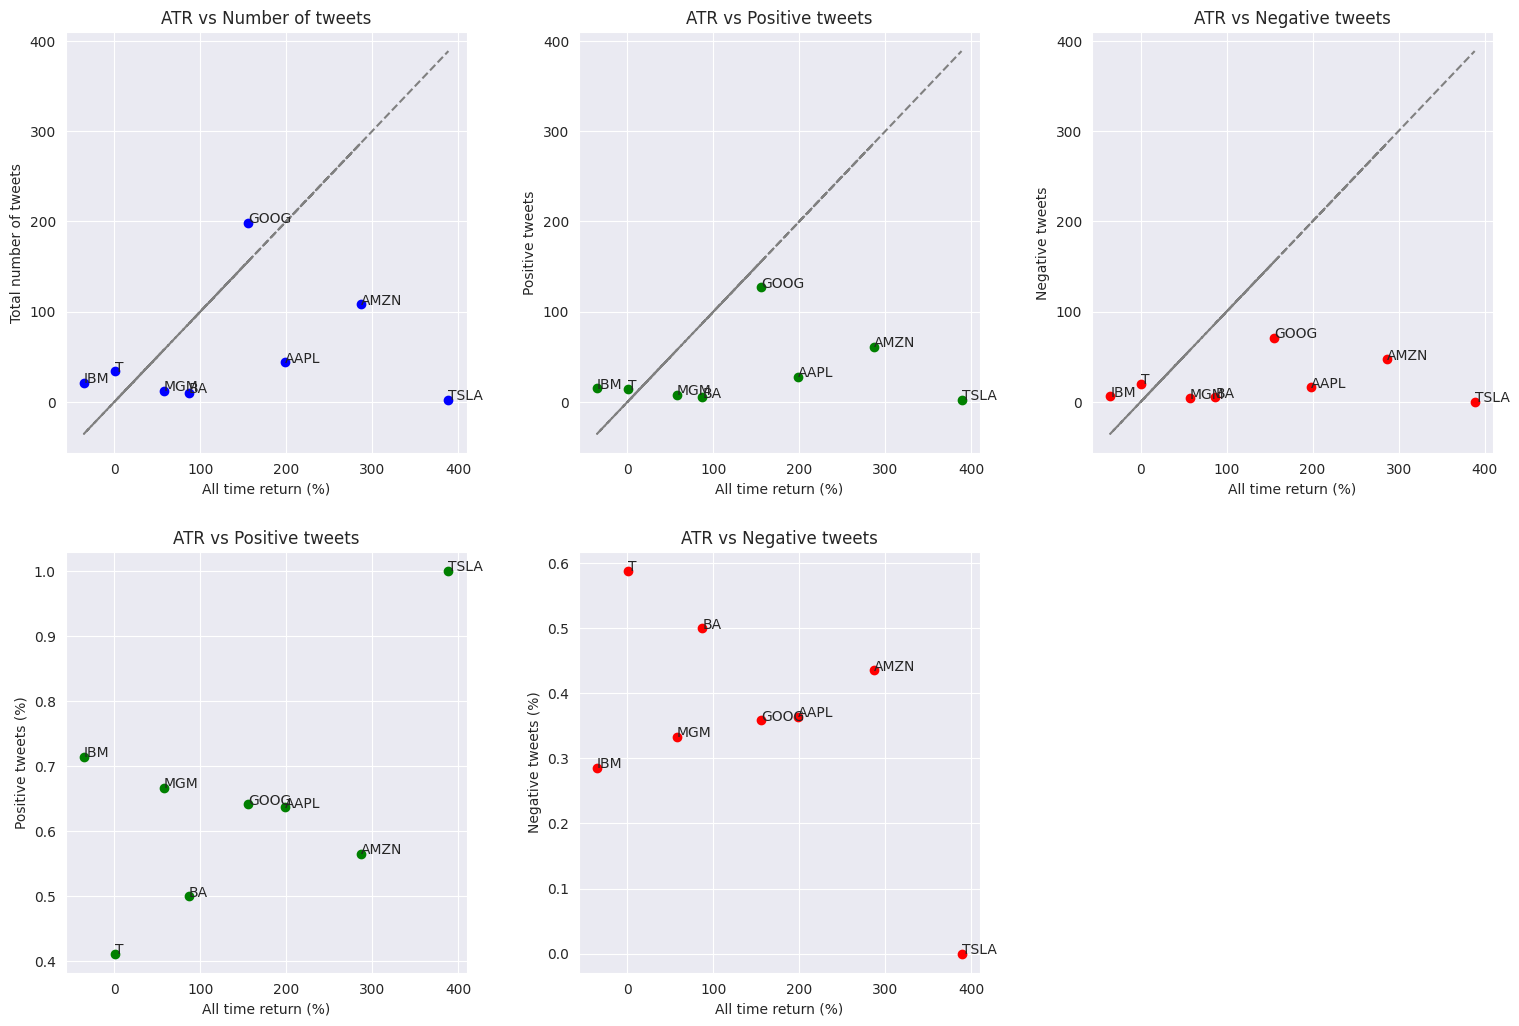

In [ ]:
sent_filtered = df_sentiment[df_sentiment.Stock.isin(selected_stocks)].sort_values(by='Stock')
sent_filtered.replace(0, np.nan, inplace=True)

# Adding relative positive and negative tweets
sent_filtered['positive %'] = sent_filtered['Positive tweets'] / sent_filtered['Number of tweets']
sent_filtered['negative %'] = sent_filtered['Negative tweets'] / sent_filtered['Number of tweets']
sent_filtered.fillna(0, inplace=True)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2 )
fig.tight_layout(w_pad=5, h_pad=5)

ax[0,0].scatter(alltime_ret, sent_filtered['Number of tweets'], color='blue')
ax[0,0].plot(alltime_ret, alltime_ret, color='grey', linestyle='--')
ax[0,0].set_xlabel('All time return (%)')
ax[0,0].set_ylabel('Total number of tweets')
ax[0,0].set_title('ATR vs Number of tweets')

ax[0,1].scatter(alltime_ret, sent_filtered['Positive tweets'], color='green')
ax[0,1].plot(alltime_ret, alltime_ret, color='grey', linestyle='--')
ax[0,1].set_xlabel('All time return (%)')
ax[0,1].set_ylabel('Positive tweets')
ax[0,1].set_title('ATR vs Positive tweets')

ax[0,2].scatter(alltime_ret, sent_filtered['Negative tweets'], color='red')
ax[0,2].plot(alltime_ret, alltime_ret, color='grey', linestyle='--')
ax[0,2].set_xlabel('All time return (%)')
ax[0,2].set_ylabel('Negative tweets')
ax[0,2].set_title('ATR vs Negative tweets')

ax[1,0].scatter(alltime_ret, sent_filtered['positive %'], color='green')
ax[1,0].set_xlabel('All time return (%)')
ax[1,0].set_ylabel('Positive tweets (%)')
ax[1,0].set_title('ATR vs Positive tweets')

ax[1,1].scatter(alltime_ret, sent_filtered['negative %'], color='red')
ax[1,1].set_xlabel('All time return (%)')
ax[1,1].set_ylabel('Negative tweets (%)')
ax[1,1].set_title('ATR vs Negative tweets')

ax[1,2].axis('off')


for i, txt in enumerate(sent_filtered.Stock):
    ax[0,0].annotate(txt, (alltime_ret[i], sent_filtered['Number of tweets'].iloc[i]))
    ax[0,1].annotate(txt, (alltime_ret[i], sent_filtered['Positive tweets'].iloc[i]))
    ax[0,2].annotate(txt, (alltime_ret[i], sent_filtered['Negative tweets'].iloc[i]))
    ax[1,0].annotate(txt, (alltime_ret[i], sent_filtered['positive %'].iloc[i]))
    ax[1,1].annotate(txt, (alltime_ret[i], sent_filtered['negative %'].iloc[i]))

plt.show()

From the plots above we can see that there is no correlation at all among the media attention and the excess returns of a stock.

Given the lack of information about the tweet, we assumed that the tweets have been posted in the same timeframe of the returns dataset. From this assumption we decided to compute the returns of each stock as the total return of the period, as if we bought the stock in the first day of the dataset and sold it in the last one.

We both analyzed the absolute and relative number of tweets about a stock. In fact we care about the media attention (as the absolute number of tweets) that a stock generates to measure the correlation with the excess returns. On the other hand it is important to consider the proportion of positive and negative tweets, since we expect oppositve correlation with the returns of a stock.

In conclusion, this analysis did not provide us with a valid factor to be included in our final model.